# Download the spectra for each source

In [49]:
%matplotlib inline
import sys, os, glob, copy, re, shutil

from astropy.io import fits, ascii
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table
from astropy.convolution import Box1DKernel, convolve
from astroquery.sdss import SDSS
from astropy.wcs import WCS

from astropy.io import fits

from astropy.table import QTable, Table, Column

import scienceplots

plt.style.use(['bright', 'science', 'no-latex','notebook'])

read tables 

**This notebook does not change these tables**

In [50]:
data_agn_updated = ascii.read('des_agn_updated.txt')
data_agn = ascii.read('des_agn.txt')

ra, dec = data_agn_updated['RA'], data_agn_updated['dec']
data_coords = SkyCoord(ra, dec, unit=[u.deg, u.deg])

prepare a table for downloading flag (?) 

In [51]:
data_agn_download = copy.deepcopy(data_agn_updated)

In [52]:
data_agn_download

Name,RA,dec,g,SNR,sigma_LB,lgM,dchi2,lgtau,z_ph,z_ph_plus,z_ph_minus,z_sp,z_sp source,W1-W2,lgF,Field,z_simb,r_z_simb,z_ozdes,z_best,ID
str20,float64,float64,float64,float64,float64,str14,float64,str16,float64,float64,str4,float64,str4,float64,float64,str5,float64,str19,float64,float64,int64
J032833.79-271056.42,52.1408,-27.1823,23.7,14.2,13.3,$10.1 \pm 0.4$,0.1,$3.2 \pm 0.6$,1.02,0.03,0.04,nan,None,0.4,nan,SN-C3,-1.0,--,-1.0,-1.0,1
J032951.20-271057.43,52.4633,-27.1826,23.4,15.3,12.7,$7.8 \pm 0.7$,0.1,$1.9 \pm 0.3$,0.24,0.04,0.02,nan,None,18.6,nan,SN-C3,-1.0,--,-1.0,-1.0,2
J032944.64-271107.53,52.436,-27.1854,23.4,20.1,16.3,$9.4 \pm 0.5$,0.0,$2.4 \pm 0.8$,1.09,0.02,0.02,nan,None,0.9,nan,SN-C3,-1.0,--,-1.0,-1.0,3
J032845.45-271117.18,52.1894,-27.1881,21.5,22.8,18.3,$9.7 \pm 0.0$,5.0,$1.7 \pm 0.2$,1.3,0.1,0.15,nan,None,1.1,nan,SN-C3,-1.0,--,-1.0,-1.0,4
J032843.19-271117.75,52.1799,-27.1883,23.8,13.4,12.4,$8.8 \pm 0.5$,0.0,$2.7 \pm 0.8$,0.6,0.25,0.05,nan,None,nan,nan,SN-C3,-1.0,--,-1.0,-1.0,5
J032850.22-271208.00,52.2093,-27.2022,19.2,26.1,20.3,$10.2 \pm 0.6$,0.0,$2.7 \pm 0.6$,0.9,0.4,0.30,nan,None,1.1,nan,SN-C3,0.803,2017AJ....153..107T,0.8018800020217896,0.8018800020217896,6
J032913.11-271213.79,52.3046,-27.2038,22.9,21.6,17.2,$10.4 \pm 0.5$,0.3,$2.2 \pm 0.7$,1.25,0.15,0.10,nan,None,1.0,nan,SN-C3,-1.0,--,-1.0,-1.0,7
J032847.11-271553.99,52.1963,-27.265,21.1,23.6,19.0,$7.3 \pm 0.1$,3.2,$3.6 \pm 0.4$,0.08,0.03,0.04,2.9784,2dF,18.1,nan,SN-C3,-1.0,--,-1.0,-1.0,8
J033039.78-271740.97,52.6658,-27.2947,24.1,10.0,11.7,$9.6 \pm 0.5$,0.4,$1.9 \pm 0.4$,1.45,0.02,0.02,nan,None,nan,nan,SN-C3,-1.0,--,-1.0,-1.0,9


### Dataset overview

The following sources have a publically available spectra

* VIMOS
* Keck
* CDF-S
* VIPERS
* GAMA
* DESI
* SDSS

The following sources need more inspection: 

* https://ui.adsabs.harvard.edu/abs/2009ApJ...703.1778S/abstract 


## VIMOS p74

In [53]:
filename_list = []
RA_list = []
DEC_list = []


### Look at all files ending in `.fits` in the vimos_p74 folder and grab the file ID, RA, and DEC directly from the full file name
for file in glob.glob('VIMOS_data/vimos_p74/**/*.fits', recursive=True):
    if not 'vimos' in os.path.basename(file):
        vimos_ra = float(os.path.basename(file)[3:11])
        vimos_dec = -float(os.path.basename(file)[12:20])
        short_name = os.path.basename(file)[0:30]

        filename_list.append(short_name)
        RA_list.append(vimos_ra)
        DEC_list.append(vimos_dec)

### Change to filename_list to np.array to be able to use in the QTable function
filename_list = np.array(filename_list)

### Find matches between source and our data table
vimos_p74_data_table = QTable([filename_list, RA_list, DEC_list], names = ('File Name', 'RA', 'DEC'))

vimos_p74_coords = SkyCoord(vimos_p74_data_table['RA'], vimos_p74_data_table['DEC'], unit='deg')

idx_vimos_p74, idx_data, d2d, _ = data_coords.search_around_sky(vimos_p74_coords, 0.5*u.arcsec)


### Table that links the matches to the ID in our data table
### IMPORTANT: rename file to <source/source ID >_<our ID>.fits
newTable = QTable([filename_list[idx_vimos_p74], idx_data + 1], names = ('file', 'ID'))

print(newTable)


             file               ID
------------------------------ ---
opt53.25251M27.58261.vm_lr.obj 258
opt53.33786M27.65328.vm_mr.obj 222
opt53.25251M27.58261.vm_mr.obj 258
opt53.33786M27.65328.vm_lr.obj 222
opt53.26510M27.75519.vm_mr.obj  47
opt53.26510M27.75519.vm_lr.obj  47


#### Flag

In [54]:
### Add a flag to master data table indicating which source the spectra for the target came from

data_agn_download['spec_vimos_p74'] = False
data_agn_download['z_vimos_p74'] = -1.

for i in range(len(idx_data)): 
    data_agn_download['spec_vimos_p74'][idx_data[i]] = True

## VIMOS p80

In [55]:
### Read catalogue file
cat_vimos_p80 = ascii.read('VIMOS_data/vimos_p80/vimos_p80.cat', format = 'csv', delimiter = '\t', names = ('ID','redshift', 'confidence', 'class', 'ra(J2000)', 'dec(J2000)', 'Rmab(AB)'))


### Grab RA, DEC, and file name (ID) for each target, and create a table with these values
vimos_p80_RA = cat_vimos_p80['ra(J2000)']
vimos_p80_DEC = cat_vimos_p80['dec(J2000)']
vimos_p80_ID = cat_vimos_p80['ID']

vimos_p80_data_table = QTable([vimos_p80_ID, vimos_p80_RA, vimos_p80_DEC], names = ('ID', 'RA', 'DEC'))


### Find matches between source and our data table
vimos_p80_coords = SkyCoord(vimos_p80_data_table['RA'], vimos_p80_data_table['DEC'], unit='deg')

idx_vimos, idx_data, d2d, _ = data_coords.search_around_sky(vimos_p80_coords, 0.5*u.arcsec)

len(idx_vimos), len(np.unique(idx_data))


### Table that links the matches to the ID in our data table
### IMPORTANT: rename file to <source/source ID >_<our ID>.fits
newTable = QTable([vimos_p80_ID[idx_vimos], idx_data + 1], names = ('file', 'ID'))

print(newTable)


file  ID
---- ---
 516 226
 550  47


#### Flag

In [56]:
data_agn_download['spec_vimos_p80'] = False
data_agn_download['z_vimos_p80'] = -1.

for i in range(len(idx_data)): 
    data_agn_download['spec_vimos_p80'][idx_data[i]] = True

## Keck

In [57]:
### Read catalogue file
cat_keck = ascii.read('keck_data/keck2007_targets.asc~', format = 'csv', delimiter = ' ', names = ('ID', 'RA', 'DEC'))


### Grab RA, DEC, and file name (ID) for each target, and create a table with these values
keck_RA = cat_keck['RA']
keck_DEC = cat_keck['DEC']
keck_ID = cat_keck['ID']

keck_data_table = QTable([keck_ID, keck_RA, keck_DEC], names = ('ID', 'RA', 'DEC'))


### Find matches between source and our data table
keck_coords = SkyCoord(keck_data_table['RA'], keck_data_table['DEC'], unit=(u.hour, u.deg))

idx_vimos, idx_data, d2d, _ = data_coords.search_around_sky(keck_coords, 0.5*u.arcsec)

len(idx_vimos), len(np.unique(idx_data))


### Table that links the matches to the ID in our data table
### IMPORTANT: rename file to <source/source ID >_<our ID>.fits
newTable = QTable([keck_ID[idx_vimos], idx_data + 1], names = ('file', 'ID'))

print(newTable)


 file  ID
----- ---
10004  47
  625 132
  532 248
  661 130
  344 108
  199 110


#### Flag

In [58]:
data_agn_download['spec_keck'] = False
data_agn_download['z_keck'] = -1.

for i in range(len(idx_data)): 
    data_agn_download['spec_keck'][idx_data[i]] = True

## CDFS

In [59]:
### Read catalogue file
cat_CDFS = ascii.read('CDFS.dat', format = 'csv', delimiter = ' ')


### Grab RA, DEC, and file name (ID) for each target, and create a table with these values
CDFS_RA = cat_CDFS['ra']
CDFS_DEC = cat_CDFS['dec']
CDFS_ID = cat_CDFS['#id']

CDFS_data_table = QTable([CDFS_ID, CDFS_RA, CDFS_DEC], names = ('ID', 'RA', 'DEC'))


### Find matches between source and our data table
CDFS_coords = SkyCoord(CDFS_data_table['RA'], CDFS_data_table['DEC'], unit='deg')

idx_vimos, idx_data, d2d, _ = data_coords.search_around_sky(CDFS_coords, 0.5*u.arcsec)

len(idx_vimos), len(np.unique(idx_data))


### Table that links the matches to the ID in our data table
### IMPORTANT: rename file to <source/source ID >_<our ID>.fits
newTable = QTable([CDFS_ID[idx_vimos], idx_data + 1], names = ('file', 'ID'))

print(newTable)


file  ID
---- ---
  4a  47
  13 226
 42a  44
 44a  43
  52 225
 539  42


#### Flag

In [60]:
data_agn_download['spec_CDFS'] = False
data_agn_download['z_CDFS'] = -1.

for i in range(len(idx_data)): 
    data_agn_download['spec_CDFS'][idx_data[i]] = True

## VIPERS W1 PDR 1

In [61]:
### Read catalogue file
cat_vipers_w1_pdr1 = ascii.read('VIPERS_data/VIPERS_W1_SPECTRO_PDR1.txt', format = 'csv', delimiter = '\t', names = ('File Name', 'ID', 'RA', 'DEC', 'selmag', 'errselmag', 'pointing', 'quadrant', 'zflg', 'zspec', 'epoch', 'photoMask', 'tsr', 'ssr'))


### Grab RA, DEC, and file name (ID) for each target, and create a table with these values
vipers_w1_pdr1_RA = cat_vipers_w1_pdr1['RA']
vipers_w1_pdr1_DEC = cat_vipers_w1_pdr1['DEC']
vipers_w1_pdr1_ID = cat_vipers_w1_pdr1['File Name']

vipers_w1_pdr1_data_table = QTable([vipers_w1_pdr1_ID, vipers_w1_pdr1_RA, vipers_w1_pdr1_DEC], names = ('ID', 'RA', 'DEC'))


### Find matches between source and our data table
vipers_w1_pdr1_coords = SkyCoord(vipers_w1_pdr1_data_table['RA'], vipers_w1_pdr1_data_table['DEC'], unit='deg')

idx_vipers_w1_pdr1, idx_data, d2d, _ = data_coords.search_around_sky(vipers_w1_pdr1_coords, 0.5*u.arcsec)

len(idx_vipers_w1_pdr1), len(np.unique(idx_data))


### Table that links the matches to the ID in our data table
### IMPORTANT: rename file to <source/source ID >_<our ID>.fits
newTable = QTable([vipers_w1_pdr1_ID[idx_vipers_w1_pdr1], idx_data + 1], names = ('file', 'id'))

print(newTable)

      file        id
---------------- ---
VIPERS 124049541 575
VIPERS 124026623 580
VIPERS 124030591 587
VIPERS 115183366 605
VIPERS 124048914 586
VIPERS 116174831 630
VIPERS 116184272 612
VIPERS 125108479 559
VIPERS 125036661 616
VIPERS 115115472 643
VIPERS 116130634 680


#### Flag

In [62]:
### Add a flag to master data table indicating which source the spectra for the target came from

data_agn_download['spec_vipers_w1_pdr1'] = False
data_agn_download['z_vipers_w1_pdr1'] = -1.

for i in range(len(idx_data)): 
    data_agn_download['spec_vipers_w1_pdr1'][idx_data[i]] = True

## VIPERS W1 PDR 2

In [63]:
### Read catalogue file
cat_vipers_w1_pdr2 = ascii.read('VIPERS_data/VIPERS_W1_SPECTRO_PDR2.txt', format = 'csv', delimiter = ' ')


### Grab RA, DEC, and file name (ID) for each target, and create a table with these values
vipers_w1_pdr2_RA = cat_vipers_w1_pdr2['alpha']
vipers_w1_pdr2_DEC = cat_vipers_w1_pdr2['delta']
vipers_w1_pdr2_ID = cat_vipers_w1_pdr2['#id_IAU']

vipers_w1_pdr2_data_table = QTable([vipers_w1_pdr2_ID, vipers_w1_pdr2_RA, vipers_w1_pdr2_DEC], names = ('ID', 'RA', 'DEC'))


### Find matches between source and our data table
vipers_w1_pdr2_coords = SkyCoord(vipers_w1_pdr2_data_table['RA'], vipers_w1_pdr2_data_table['DEC'], unit='deg')

idx_vipers_w1_pdr2, idx_data, d2d, _ = data_coords.search_around_sky(vipers_w1_pdr2_coords, 0.5*u.arcsec)

len(idx_vipers_w1_pdr2), len(np.unique(idx_data))


### Table that links the matches to the ID in our data table
### IMPORTANT: rename file to <source/source ID >_<our ID>.fits
newTable = QTable([vipers_w1_pdr2_ID[idx_vipers_w1_pdr2], idx_data + 1], names = ('file', 'id'))

print(newTable)

      file        id
---------------- ---
VIPERS 115112315 642
VIPERS 115115472 643
VIPERS 115183366 605
VIPERS 116071987 673
VIPERS 116084339 675
VIPERS 116130634 680
VIPERS 116174831 630
VIPERS 116184272 612
VIPERS 124030591 587
VIPERS 124048914 586
VIPERS 125036661 616
VIPERS 125108479 559


#### Flag

In [64]:
### Add a flag to master data table indicating which source the spectra for the target came from

data_agn_download['spec_vipers_w1_pdr2'] = False
data_agn_download['z_vipers_w1_pdr2'] = -1.

for i in range(len(idx_data)): 
    data_agn_download['spec_vipers_w1_pdr2'][idx_data[i]] = True

## GAMA

#### Use premade query formats found on GAMA website to make a catalogue file, if necesssary

In [65]:
### Read catalogue file
cat_gama = ascii.read('GAMA_data/GAMASpecObj.txt', format = 'csv', delimiter = ' ', names = ('CATAID', 'GAMA_NAME', 'IC_FLAG', 'N_SPEC', 'N_GAMA_SPEC', 'DIST', 'SPECID', 'SURVEY', 'SURVEY_CODE', 'RA', 'DEC', 'WMIN', 'WMAX', 'Z', 'NQ', 'PROB', 'FILENAME', 'URL', 'URL_IMG'))


### Grab RA, DEC, and file name (ID) for each target, and create a table with these values
gama_RA = cat_gama['RA']
gama_DEC = cat_gama['DEC']
gama_ID = cat_gama['URL']

gama_data_table = QTable([gama_ID, gama_RA, gama_DEC], names = ('ID', 'RA', 'DEC'))


### Find matches between source and our data table
gama_coords = SkyCoord(gama_data_table['RA'], gama_data_table['DEC'], unit='deg')

idx_gama, idx_data, d2d, _ = data_coords.search_around_sky(gama_coords, 0.5*u.arcsec)

len(idx_gama), len(np.unique(idx_data))


### Table that links the matches to the ID in our data table
### IMPORTANT: rename file to <source/source ID >_<our ID>.fits
newTable = QTable([gama_ID[idx_gama], idx_data + 1], names = ('file', 'ID'))

newTable

file,ID
str88,int64
http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G02_Y5_095_247.fit,700
http://www.gama-survey.org/dr3/data/spectra/sdss/spec-4387-55534-0360.fit,701
http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G02_Y3_006_229.fit,695
http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G02_Y5_089_288.fit,698
http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G02_Y5_093_249.fit,703
http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G02_Y3_016_161.fit,704
http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G02_Y5_095_344.fit,706
http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G02_Y3_009_186.fit,705
http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G02_Y5_079_245.fit,699


#### Flag

In [66]:
data_agn_download['spec_GAMA'] = False
data_agn_download['z_GAMA'] = -1.

for i in range(len(idx_data)): 
    data_agn_download['spec_GAMA'][idx_data[i]] = True

## DESI

Rename the DESI spectra to follow the naming convention

Load txt file with 6 matches
These matches come from Charlotte Ward (Email)

In [67]:
import shutil

desi_targets = ascii.read('DESI_Matches2.csv', format = 'csv')

#print(desi_targets.colnames)

desi_RA = desi_targets['RA']
desi_DEC = desi_targets['DEC']
desi_ID = desi_targets['Name']

desi_data_table = QTable([desi_ID, desi_RA, desi_DEC], names = ('Name', 'RA', 'DEC'))

desi_coords = SkyCoord(desi_targets['RA'], desi_targets['DEC'], unit='deg')

idx_desi, idx_data, d2d, _ = data_coords.search_around_sky(desi_coords, 0.5*u.arcsec)



newTable = QTable([desi_ID[idx_desi], idx_data + 1], names = ('file', 'ID'))

newTable

file,ID
str20,int64
J022833.54-040141.58,536
J022631.23-042129.13,568
J022326.46-045706.17,653
J022415.76-052720.24,657
J022717.89-051623.98,663
J022319.71-052002.55,669


Move and rename the fetched spec (uncomment if needed to do it again)

In [68]:
# Rename the files
for i,idx in enumerate(idx_data):
    shutil.copy('desi_data/%s_spec.txt'%desi_targets['Name'][idx_desi][i], 'spec/DESI/desi_%d.txt'%(idx+1))

len(idx_desi), len(np.unique(idx_data))

(6, 6)

In [69]:
data_agn_download['spec_desi'] = False
data_agn_download['z_desi'] = -1.

for i in range(len(idx_data)):
    data_agn_download['spec_desi'][idx_data[i]] = True

## SDSS 

Download the spectra and label the table at once: 

In [70]:
idx_data = []
sdss_targets = []

for i in range(len(data_agn_updated)): 
    pos = data_coords[i]
    xid = SDSS.query_region(pos, radius='0.5 arcsec', spectro=True)
    
    if xid is None: 
        continue
    
    print(i+1)
    print(xid['objid'])
    if len(xid)>=2: 
        print(i+1, 'has multiple spectra: ')
        xid.pprint_all()
    # else: 
    #     print(i+1, 'has a spectrum')
    sdss_targets.append(xid)
    idx_data.append(i)

len(idx_data)


536
       objid       
-------------------
1237679254672638675
540
       objid       
-------------------
1237679323399061769
1237679323399061769
540 has multiple spectra: 
       ra               dec               objid        run  rerun camcol field      z       plate  mjd  fiberID      specobjid       run2d 
---------------- ----------------- ------------------- ---- ----- ------ ----- ------------ ----- ----- ------- ------------------- -------
36.8989126162853 -4.19002607867761 1237679323399061769 7881   301      4   268 -0.001738581  6369 56217     979 7171125716456546304 v5_10_0
36.8989126162853 -4.19002607867761 1237679323399061769 7881   301      4   268      1.11976  7235 56603     640 8146061858647810048 v5_10_0
541
       objid       
-------------------
1237679323399127114
542
       objid       
-------------------
1237679323399061797
548
       objid       
-------------------
1237679323399061697
1237679323399061697
548 has multiple spectra: 
       ra               de

/Users/diegomiura/anaconda3/envs/astro-rps/lib/python3.11/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


75

fill in the table

In [71]:
data_agn_download['spec_sdss'] = False
data_agn_download['z_sdss'] = -1. 
for i in range(len(idx_data)): 
    data_agn_download['spec_sdss'][idx_data[i]] = True
    data_agn_download['z_sdss'][idx_data[i]] = sdss_targets[i]['z'][-1]

download the spectra

In [72]:
sdss_dir = 'spec/SDSS'
for i in range(len(idx_data)): 
    sp = SDSS.get_spectra(matches=sdss_targets[i])
    sp[-1].writeto(os.path.join(sdss_dir, 'sdss_'+str(data_agn_download[idx_data][i]['ID'])+'.fits'), overwrite=True) # if more than 1, then the last one (-1) is probably the newest

Notes: 
* ID=283 and 280 have 2 spectra at its coordinate but their data are very close 
* If we change radius to 3 arcsec we can get more result with no overlapping 

## Summary

Check how many spectra each target has: 

In [73]:
data_agn_download.pprint_all()

        Name            RA     dec     g   SNR  sigma_LB      lgM       dchi2      lgtau       z_ph z_ph_plus z_ph_minus  z_sp  z_sp source W1-W2  lgF   Field  z_simb        r_z_simb            z_ozdes              z_best        ID spec_vimos_p74 z_vimos_p74 spec_vimos_p80 z_vimos_p80 spec_keck z_keck spec_CDFS z_CDFS spec_vipers_w1_pdr1 z_vipers_w1_pdr1 spec_vipers_w1_pdr2 z_vipers_w1_pdr2 spec_GAMA z_GAMA spec_desi z_desi spec_sdss    z_sdss   
-------------------- ------- -------- ---- ---- -------- -------------- ----- ---------------- ---- --------- ---------- ------ ----------- ----- ------ ----- -------- ------------------- ------------------- ------------------- --- -------------- ----------- -------------- ----------- --------- ------ --------- ------ ------------------- ---------------- ------------------- ---------------- --------- ------ --------- ------ --------- ------------
J032833.79-271056.42 52.1408 -27.1823 23.7 14.2     13.3 $10.1 \pm 0.4$   0.1    $3.2 \pm 0.6$ 1.0

In [74]:
data_agn_download[534]

Name,RA,dec,g,SNR,sigma_LB,lgM,dchi2,lgtau,z_ph,z_ph_plus,z_ph_minus,z_sp,z_sp source,W1-W2,lgF,Field,z_simb,r_z_simb,z_ozdes,z_best,ID,spec_vimos_p74,z_vimos_p74,spec_vimos_p80,z_vimos_p80,spec_keck,z_keck,spec_CDFS,z_CDFS,spec_vipers_w1_pdr1,z_vipers_w1_pdr1,spec_vipers_w1_pdr2,z_vipers_w1_pdr2,spec_GAMA,z_GAMA,spec_desi,z_desi,spec_sdss,z_sdss
str20,float64,float64,float64,float64,float64,str14,float64,str16,float64,float64,str4,float64,str4,float64,float64,str5,float64,str19,float64,float64,int64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64
J022840.37-040343.83,37.1682,-4.0622,22.8,16.3,14.9,$8.1 \pm 0.2$,1.3,$2.9 \pm 0.9$,0.25,0.01,0.03,nan,None,17.8,nan,SN-X3,-1.0,--,-1.0,-1.0,535,False,-1.0,False,-1.0,False,-1.0,False,-1.0,False,-1.0,False,-1.0,False,-1.0,False,-1.0,False,-1.0


In [75]:
data_agn_download[535]

Name,RA,dec,g,SNR,sigma_LB,lgM,dchi2,lgtau,z_ph,z_ph_plus,z_ph_minus,z_sp,z_sp source,W1-W2,lgF,Field,z_simb,r_z_simb,z_ozdes,z_best,ID,spec_vimos_p74,z_vimos_p74,spec_vimos_p80,z_vimos_p80,spec_keck,z_keck,spec_CDFS,z_CDFS,spec_vipers_w1_pdr1,z_vipers_w1_pdr1,spec_vipers_w1_pdr2,z_vipers_w1_pdr2,spec_GAMA,z_GAMA,spec_desi,z_desi,spec_sdss,z_sdss
str20,float64,float64,float64,float64,float64,str14,float64,str16,float64,float64,str4,float64,str4,float64,float64,str5,float64,str19,float64,float64,int64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64
J022833.54-040141.58,37.1397,-4.0282,21.9,9.1,12.2,$8.6 \pm 0.2$,0.9,$1.7 \pm 0.2$,0.7,0.45,0.10,nan,None,17.5,nan,SN-X3,0.84104,2020ApJS..249....3A,-1.0,0.84104,536,False,-1.0,False,-1.0,False,-1.0,False,-1.0,False,-1.0,False,-1.0,False,-1.0,True,-1.0,True,0.8408439


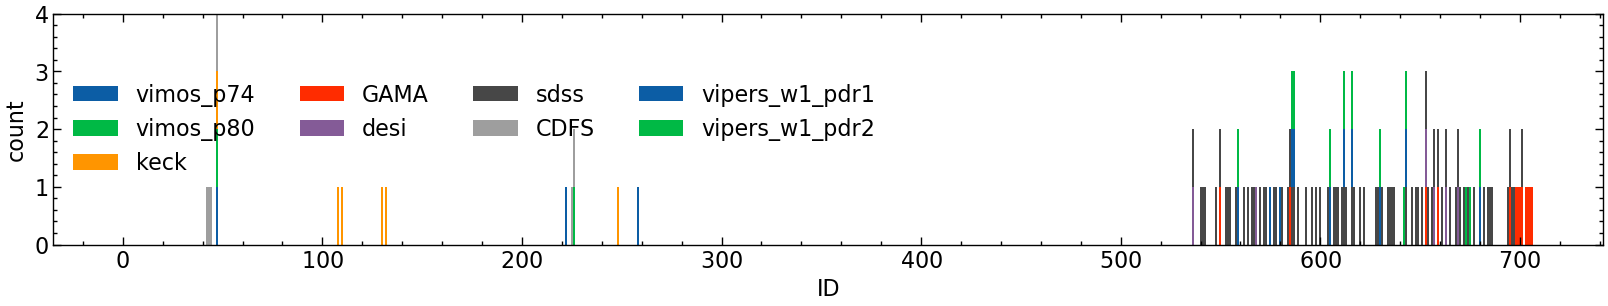

In [76]:
plt.figure(figsize=[20, 3])
spectra_counts = np.zeros(len(data_agn_download))
for flag in ['spec_vimos_p74', 'spec_vimos_p80', 'spec_keck', 'spec_GAMA', 'spec_desi', 'spec_sdss', 'spec_CDFS', 'spec_vipers_w1_pdr1', 'spec_vipers_w1_pdr2']: 
    plt.bar(data_agn_download['ID'], data_agn_download[flag], width=1, bottom=spectra_counts, label=flag[5:])
    spectra_counts += data_agn_download[flag]
plt.xlabel('ID')
plt.ylabel('count')
plt.legend(ncol=4)
#plt.xlim(-3, 495)
#plt.ylim(0, 10)

Visually check if most of the targets having more than 2 spectra is consistent

### Vizualize spectra

Seems like zCOSMOS, SDSS, DESI are usually good.

Flux calibration of Magellan spectra is often too high, and DEIMOS flux calibration is usually bad.

* VIMOS p80
* CDF-S
* VIPERS

In [77]:
line_cen = np.array( [6564.60,            4862.68,    2797,    1908, 1549.06, 1215.67])
line_name = np.array([r'H$\alpha$+[NII]', r'H$\beta$','MgII'  , 'CIII]', 'CIV',   r'Ly$\alpha$'])

wmin = 4000
wmax = 11000

# # for i, ID in enumerate(data_agn_download['ID'][z_count>=2]): 
# for i,ID in enumerate(data_inconsistent_spec['ID']):
# # for i,ID in enumerate(data_agn_download['ID'][252:256]):
    
def visualize(ID, plot_template=True):

    ra = data_agn_download['RA'][data_agn_download['ID']==ID].data[0]
    dec = data_agn_download['dec'][data_agn_download['ID']==ID].data[0]

    fig, ax = plt.subplots(1,1, figsize=(8,4.5))
    
    
    ylim = 0
    z_zcosmos = -1
    z_magellan = -1
    z_deimos = -1
    z_sdss = -1
    z_desi = -1
    z_3dhst = -1
    z_legac = -1
    

    # GAMA
    if os.path.isfile('spec/GAMA_%d.fits'%ID): 

        z_gama = data_agn_download['z_best'][ID-1]

        hdul_gama = fits.open('spec/GAMA_%d.fits'%ID)
        data_gama = hdul_gama[0].data

        flux_gama = convolve(data_gama['ROW1'][0], Box1DKernel(width=10))
        #flux_err_gama = convolve(data_gama['ROW2'][0], Box1DKernel(width=10))
        w_min_gama = convolve(data_gama['WMIN'][0], Box1DKernel(width=10))
        w_max_gama = convolve(data_gama['WMAX'][0], Box1DKernel(width=10))
        step_gama = convolve(data_gama['CD1_1'][0], Box1DKernel(width=10))

        wave_gama = np.arange(w_min_gama, w_max_gama, step_gama)

        ax.plot(wave_gama, flux_gama, 
                label=f'GAMA (z={z_gama})', color='coral', linewidth=1, alpha=0.5)
        #plt.fill_between(data1[0], flux_gama-flux_err_gama, flux_gama+flux_err_catalog,
        #                 color='skyblue', linewidth=0, alpha=0.1)
        
        mask_gama = np.isfinite(flux_gama)
        ylim = np.max([ylim, np.nanmax(flux_gama[mask_gama])])
    

    # Keck
    if os.path.isfile('spec/Keck/keck_%d.fits'%ID): 

        z_keck = data_agn_download['z_best'][ID-1]

        hdul_keck = fits.open('spec/Keck/keck_%d.fits'%ID)
        #data_keck = hdul_keck[0].data

        # mask
        #mask_keck = np.full(data_keck[1].shape, np.nan)
        #mask_keck[data_keck[3]>0] = data_keck[1][data_keck[3]>0]

        spec_boxcar_B = hdul_keck[1].data['SPEC'][0]
        spec_boxcar_R = hdul_keck[2].data['SPEC'][0]

        wave_boxcar_B = hdul_keck[1].data['LAMBDA'][0]
        wave_boxcar_R = hdul_keck[2].data['LAMBDA'][0]


        spec_boxcar_conc = np.concatenate((spec_boxcar_B, spec_boxcar_R))
        wave_boxcar_conc = np.concatenate((wave_boxcar_B, wave_boxcar_R))
        
        ax.plot(wave_boxcar_conc, spec_boxcar_conc, 
                label=f'Keck (z={z_keck})', color='deepskyblue', linewidth=1, alpha=0.5)
        
        mask = np.isfinite(spec_boxcar_conc)
        ylim = np.max([ylim, np.nanmax(spec_boxcar_conc[mask])])


    # VIMOS p74
    #if os.path.isfile('spec/vimos_p74_spectra/vimos_%d.fits'%ID): 

        #z_vimos_p74 = data_agn_download['z_best'][ID-1]

        #hdu3 = fits.open('spec/vimos_p74_spectra/vimos_%d.fits'%ID)
        #print(hdu3[0].header)
        
        #data3 = hdu3[1].data
        # if 'FLUX' in data3.names:
        #     continue
        #flux_vimos_p74 = convolve(data3['FLUX'][0]*1e-19/1e-17, Box1DKernel(width=20))
        #flux_err_deimos = convolve(1/np.sqrt(data3['IVAR'][0])*1e-19/1e-17, Box1DKernel(width=50))
        # No error providede, assume ~10%
        #flux_err_vimos_p74 = 0.1*flux_vimos_p74
        
        #ax.plot(data3['LAMBDA'][0], flux_vimos_p74, 
                #label=f'VIMOS p74 (z={z_deimos})', color='orchid', linewidth=1, alpha=0.5)
        #plt.fill_between(data3['LAMBDA'][0], flux_vimos_p74-flux_err_vimos_p74, flux_vimos_p74+flux_err_vimos_p74,
        #                 color='forestgreen', linewidth=0, alpha=0.1)
        
        #mask = np.isfinite(flux_vimos_p74)
        #ylim = np.max([ylim, np.nanmax(flux_vimos_p74[mask])])

                
    # SDSS
    
    if os.path.isfile('spec/SDSS/sdss_%d.fits'%ID): 
        
        z_sdss = data_agn_download['z_best'][ID-1]

        hdul_sdss= fits.open('spec/SDSS/sdss_%d.fits'%ID)
        mask_sdss = np.isfinite(hdul_sdss[1].data['flux'])
        flux_sdss = convolve(hdul_sdss[1].data['flux'][mask_sdss], Box1DKernel(width=10))
        ax.plot(10**hdul_sdss[1].data['loglam'][mask_sdss], flux_sdss,
                 label=f'SDSS (z={z_sdss})', color='bisque', linewidth=1);
        
        mask = np.isfinite(flux_sdss)
        ylim = np.max([ylim, np.nanmax(flux_sdss[mask])])
        

    # DESI
    if os.path.isfile('spec/desi/desi_%d.txt'%ID): 

        z_desi = data_agn_download['z_desi'][ID-1]
        
        data_spec = ascii.read('spec/desi/desi_%d.txt'%ID)
        flux_desi = convolve(data_spec['col2'], Box1DKernel(width=10))
        ax.plot(data_spec['col1'], flux_desi,
                 label=f'DESI (z={z_desi})', color='g', linewidth=1);
        
        mask = np.isfinite(flux_desi)
        ylim = np.max([ylim, np.nanmax(flux_desi[mask])])


    ### Haven't found flux header
    # CDF-S
    #if os.path.isfile('spec/CDFS/cdfs_%d.fits'%ID): 

        #z_cdfs = data_agn_download['z_best'][ID-1]
        
        #hdu = fits.open('spec/CDFS/cdfs_%d.fits'%ID)

        #flux_cdfs = hdu[1].data['flux']


        #ax.plot(hdu[1].data['wave'], flux_cdfs,
                 #label=f'CDF-S (z={z_cdfs})', color='b', linewidth=1);
        
        #mask = np.isfinite(flux_cdfs)
        #ylim = np.max([ylim, np.nanmax(flux_cdfs[mask])])



    # VIPERS
    if os.path.isfile('spec/VIPERS_W1_PDR1/VIPERS_%d.fits'%ID): 

        z_gama = data_agn_download['z_best'][ID-1]

        hdul_vipers = fits.open('spec/VIPERS_W1_PDR1/VIPERS_%d.fits'%ID)

        data_vipers = hdul_vipers[1].data

        flux_gama = data_vipers['FLUXES']
        #flux_err_gama = data_vipers['NOISE']
        wave_gama = data_vipers['WAVES']

        ax.plot(wave_gama, flux_gama, 
                label=f'GAMA (z={z_gama})', color='coral', linewidth=1, alpha=0.5)
        
        mask = np.isfinite(flux_gama)
        ylim = np.max([ylim, np.nanmax(flux_gama[mask])])

        
    ax.set_xlim(wmin, wmax)
    ax.set_ylim(0.0, 1.2*ylim)

    # VIMOS p80
    #if os.path.isfile('spec/vimos_p80/vimos_p80_clean_%d.fits'%ID) or os.path.isfile('spec/vimos_p80/vimos_p80_noise_%d.fits'%ID): 
        #z_vimos_p80 = data_agn_download['z_best'][ID-1]

        #hdul_vimos_p80 = fits.open('spec/vimos_p80/vimos_p80_clean_%d.fits'%ID)

        #data_vimos_p80 = hdul_vimos_p80[1].data

        





    # TEMPLATES
    # Template data
    hdutemp = SDSS.get_spectral_template('qso')[0]
    datatemp = hdutemp[0].data
    headertemp = hdutemp[0].header
    start, stop, num = headertemp['COEFF0'], headertemp['COEFF0']+headertemp['COEFF1']*datatemp[1].size, datatemp[1].size
    # Line position
    if plot_template: 
        axis_to_data = ax.transAxes + ax.transData.inverted()
        points_data = axis_to_data.transform((0, 0.92))
        
        for z in [z_zcosmos, z_magellan, z_deimos, z_sdss, z_desi, z_3dhst, z_legac]:
            # Template
            if z > 0:
                ax.plot(np.logspace(start, stop, num)*(1 + z), datatemp[1]/np.max(datatemp[1])*ylim, #np.nanmax(flux_deimos), 
                        label=f'template (z = {z})', linewidth=1, alpha=0.75, color='k', linestyle='-')

                for ll in range(len(line_cen)):
                    if line_cen[ll]*(1 + z) > wmin and line_cen[ll]*(1 + z) < wmax:
                        ax.axvline(line_cen[ll]*(1 + z), 0, 5, linewidth=1, color='k', alpha=0.5)
                        ax.text(line_cen[ll]*(1 + z) + 7, points_data[1], line_name[ll], rotation=90, fontsize=10, va='top')
                        
    
    ax.legend(fontsize=12, loc=2);
    ax.set_ylabel(r'$f_{\lambda}$ (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1})$')
    ax.set_xlabel(r'Wavelength ($\AA$)')
    
    return ax

## How to work with FITS files

In [78]:
hdul_sdss = fits.open('spec/SDSS/sdss_536.fits')
print(len(hdul_sdss))

hdul_sdss[1].data['flux'].shape

10


(4609,)

## Visualizing spectrum

In [79]:
#for ID in data_agn_download['ID']:
    #if data_agn_download['z_best'][ID - 1] > 0:
        #visualize(ID)

<Axes: xlabel='Wavelength ($\\AA$)', ylabel='$f_{\\lambda}$ (erg s$^{-1}$ cm$^{-2}$ $\\AA^{-1})$'>

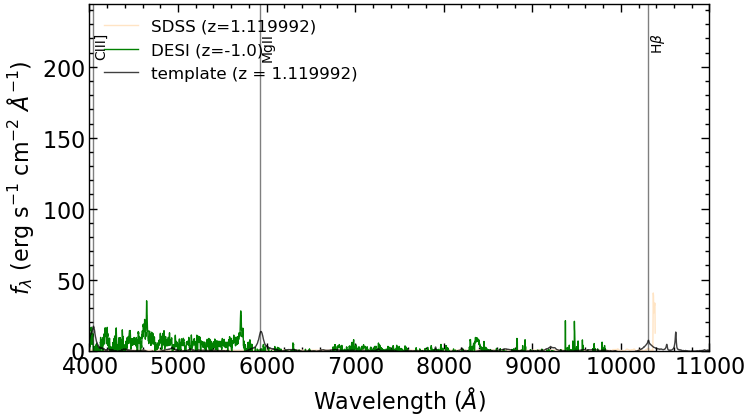

In [80]:
visualize(540)

<Axes: xlabel='Wavelength ($\\AA$)', ylabel='$f_{\\lambda}$ (erg s$^{-1}$ cm$^{-2}$ $\\AA^{-1})$'>

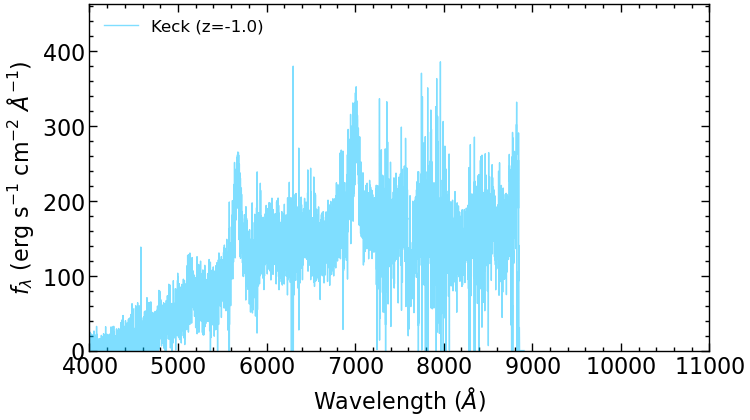

In [81]:
visualize(108)

<Axes: xlabel='Wavelength ($\\AA$)', ylabel='$f_{\\lambda}$ (erg s$^{-1}$ cm$^{-2}$ $\\AA^{-1})$'>

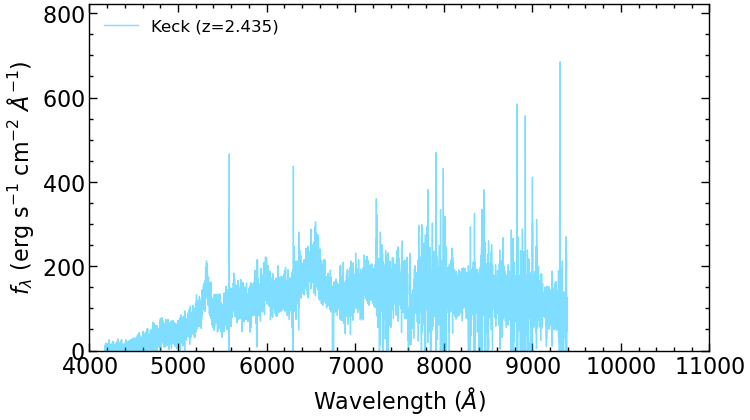

In [82]:
visualize(110)

In [83]:
data_agn_download[107:110]

Name,RA,dec,g,SNR,sigma_LB,lgM,dchi2,lgtau,z_ph,z_ph_plus,z_ph_minus,z_sp,z_sp source,W1-W2,lgF,Field,z_simb,r_z_simb,z_ozdes,z_best,ID,spec_vimos_p74,z_vimos_p74,spec_vimos_p80,z_vimos_p80,spec_keck,z_keck,spec_CDFS,z_CDFS,spec_vipers_w1_pdr1,z_vipers_w1_pdr1,spec_vipers_w1_pdr2,z_vipers_w1_pdr2,spec_GAMA,z_GAMA,spec_desi,z_desi,spec_sdss,z_sdss
str20,float64,float64,float64,float64,float64,str14,float64,str16,float64,float64,str4,float64,str4,float64,float64,str5,float64,str19,float64,float64,int64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64
J033216.14-275644.24,53.0673,-27.9456,22.6,13.3,11.3,$6.8 \pm 0.3$,1.4,$2.2 \pm 0.6$,0.06,0.03,0.01,2.6719,ACES,nan,-15.26,SN-C3,-1.0,--,-1.0,-1.0,108,False,-1.0,False,-1.0,True,-1.0,False,-1.0,False,-1.0,False,-1.0,False,-1.0,False,-1.0,False,-1.0
J033119.90-275647.94,52.8329,-27.9467,24.1,5.7,6.4,$9.8 \pm 0.5$,0.6,$2.1 \pm 0.5$,1.14,0.01,0.04,nan,None,18.7,-15.26,SN-C3,-1.0,--,-1.0,-1.0,109,False,-1.0,False,-1.0,False,-1.0,False,-1.0,False,-1.0,False,-1.0,False,-1.0,False,-1.0,False,-1.0
J033151.80-280025.88,52.9658,-28.0072,22.7,17.7,15.4,$6.8 \pm 0.5$,0.1,$2.7 \pm 0.7$,0.08,0.03,0.01,nan,None,nan,nan,SN-C3,2.435,2010ApJS..191..124S,-1.0,2.435,110,False,-1.0,False,-1.0,True,-1.0,False,-1.0,False,-1.0,False,-1.0,False,-1.0,False,-1.0,False,-1.0


In [84]:
data_agn_download[129]

Name,RA,dec,g,SNR,sigma_LB,lgM,dchi2,lgtau,z_ph,z_ph_plus,z_ph_minus,z_sp,z_sp source,W1-W2,lgF,Field,z_simb,r_z_simb,z_ozdes,z_best,ID,spec_vimos_p74,z_vimos_p74,spec_vimos_p80,z_vimos_p80,spec_keck,z_keck,spec_CDFS,z_CDFS,spec_vipers_w1_pdr1,z_vipers_w1_pdr1,spec_vipers_w1_pdr2,z_vipers_w1_pdr2,spec_GAMA,z_GAMA,spec_desi,z_desi,spec_sdss,z_sdss
str20,float64,float64,float64,float64,float64,str14,float64,str16,float64,float64,str4,float64,str4,float64,float64,str5,float64,str19,float64,float64,int64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64
J033320.02-275912.63,53.3334,-27.9868,21.5,22.1,18.4,$9.9 \pm 0.4$,0.0,$1.8 \pm 0.2$,0.65,0.4,0.30,0.6833,ACES,0.7,nan,SN-C3,0.683,2010ApJS..191..124S,-1.0,0.683,130,False,-1.0,False,-1.0,True,-1.0,False,-1.0,False,-1.0,False,-1.0,False,-1.0,False,-1.0,False,-1.0


In [85]:
data_agn_download[247]

Name,RA,dec,g,SNR,sigma_LB,lgM,dchi2,lgtau,z_ph,z_ph_plus,z_ph_minus,z_sp,z_sp source,W1-W2,lgF,Field,z_simb,r_z_simb,z_ozdes,z_best,ID,spec_vimos_p74,z_vimos_p74,spec_vimos_p80,z_vimos_p80,spec_keck,z_keck,spec_CDFS,z_CDFS,spec_vipers_w1_pdr1,z_vipers_w1_pdr1,spec_vipers_w1_pdr2,z_vipers_w1_pdr2,spec_GAMA,z_GAMA,spec_desi,z_desi,spec_sdss,z_sdss
str20,float64,float64,float64,float64,float64,str14,float64,str16,float64,float64,str4,float64,str4,float64,float64,str5,float64,str19,float64,float64,int64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64
J033300.77-275520.80,53.2532,-27.9224,21.5,23.7,17.5,$9.5 \pm 0.4$,0.1,$2.6 \pm 0.9$,0.91,0.05,0.03,2.0033,ACES,0.4,nan,SN-C3,-1.0,--,-1.0,-1.0,248,False,-1.0,False,-1.0,True,-1.0,False,-1.0,False,-1.0,False,-1.0,False,-1.0,False,-1.0,False,-1.0


Second group of plot: inconsistent z in `updated` table

manually check inconsistent zs

```
Original Chandra    -> z5
SIMBAD              -> z0
HSC DR3             -> z1
COSMOS2020          -> z3 -> do not inspect (photz)
```

SDSS template AGN spectrum: 

template spectra: https://classic.sdss.org/dr5/algorithms/spectemplates/

HDU description: https://classic.sdss.org/dr5/dm/flatFiles/spSpec.html 

One consistent target: 

In [86]:
# ID = 136

# Magellean
hdu1 = fits.open('spec/Magellan/magellan_136.fits')
data1 = hdu1[0].data
plt.plot(data1[0], data1[1], label='Magellan', linewidth=1, alpha=0.5)

# DEIMOS
hdu3 = fits.open('spec/DEIMOS/deimos_136.fits')
data3 = hdu3[1].data
box1d_kernel = Box1DKernel(width=30)
flux = convolve(data3['FLUX'][0]*1e-19, box1d_kernel)
plt.plot(data3['LAMBDA'][0], flux, label='DEIMOS smoothed', linewidth=1, alpha=0.5)
# plt.plot(data3['LAMBDA'][0], data3['FLUX'][0]*1e-18, label='DEIMOS', linewidth=0.1)

# SDSS
hdu = fits.open('spec/SDSS/sdss_136.fits')
plt.plot(10**hdu[1].data['loglam'], hdu[1].data['flux']*1e-17, label='SDSS', linewidth=1, alpha=0.5);

# template
hdutemp = SDSS.get_spectral_template('qso')[0]
datatemp = hdutemp[0].data
headertemp = hdutemp[0].header
start, stop, num = headertemp['COEFF0'], headertemp['COEFF0']+headertemp['COEFF1']*datatemp[1].size, datatemp[1].size
z_magellan = data_agn_download['z_magellan'][135]
print(z_magellan)
plt.plot(np.logspace(start, stop, num)*(1+z_magellan), datatemp[1]*1e-17, label='template with magellan z', linewidth=1, alpha=0.5)

plt.title('ID = 136 (consistent to show 3 spectra)')
plt.xlim(5000, 10000)
plt.ylim(-0.5e-16, 1e-16)
plt.legend();

FileNotFoundError: [Errno 2] No such file or directory: 'spec/Magellan/magellan_136.fits'